<a href="https://colab.research.google.com/github/paulamartingonzalez/GNN-expl/blob/main/Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
!pip install dgl 
!pip install -q captum

In [246]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.nn import GraphConv,EdgeWeightNorm
from random import randint
from torch.utils.data import DataLoader
from scipy.sparse import coo_matrix
from scipy import sparse
from captum.attr import Saliency, IntegratedGradients
from functools import partial
import pandas as pd

# Create random graphs for graph classification

In [247]:
gs=[]
node_number = 20
initial_nodes = 2
node_feats=4


for i in range(25):
    G = nx.barabasi_albert_graph(node_number, initial_nodes)
    A = nx.adjacency_matrix(G)
    g = dgl.DGLGraph(A)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), node_feats)
    label = randint(0, 1)
    gs.append((g,label))

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


# Define model

In [248]:
class GCN_edgefeats(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN_edgefeats, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.w = EdgeWeightNorm()
        self.out_act = nn.Sigmoid()
    def forward(self, g, in_feat,edge_weight):
        norm = self.w(g, edge_weight)
        h = self.conv1(g, in_feat,edge_weight=norm)
        h = F.relu(h)
        h = self.conv2(g, h,edge_weight=norm)
        g.ndata['h'] = h
        return self.out_act(dgl.mean_nodes(g, 'h'))

# Dataloader

In [249]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [250]:
train_dataloader = DataLoader(gs, batch_size=int(10), shuffle=True,
                            collate_fn=collate)

# Train

In [253]:
# Create the model with given dimensions
model = GCN_edgefeats(4, 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        edge_weight = (torch.ones(batched_graph.num_edges())).requires_grad_()
        #edge_weight = (torch.randn(batched_graph.num_edges()) ** 2).requires_grad_() 
        #edge_weight = torch.tensor(batched_graph.adj(scipy_fmt='coo').todense())
        pred = model(batched_graph, batched_graph.ndata['h_n'].float(),edge_weight)
        loss = loss_func(pred.round(), labels.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Get node importances

Select one graph:

In [261]:
graphs = dgl.unbatch(batched_graph)
G = graphs[2]
edge_weight = (torch.randn(G.num_edges()) ** 2).requires_grad_() 

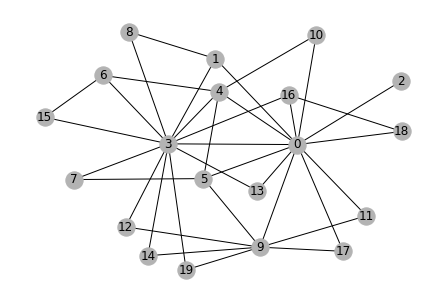

In [262]:
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Integrated gradients

In [263]:
ig = IntegratedGradients(partial(model, G,edge_weight=edge_weight))
mask = ig.attribute(G.ndata['h_n'].float(), target=0, internal_batch_size=5, n_steps=50)

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/batching.py:49: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 20 equal to the number of examples.
  % num_examples


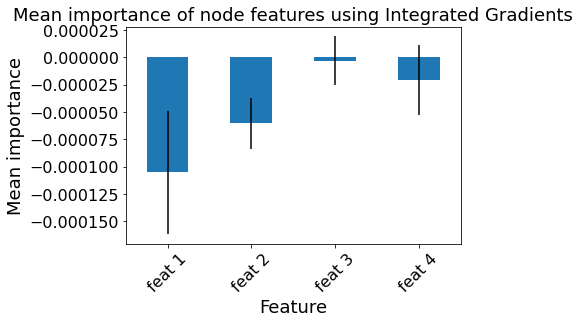

In [264]:
df = pd.DataFrame(data=mask.detach().numpy(), index=None, columns=['feat 1','feat 2','feat 3','feat 4'])
mymean = df.mean()
mysem = df.sem()

p = mymean.plot(legend=False,kind="bar",rot=45,fontsize=16,yerr=mysem);
p.set_title("Mean importance of node features using Integrated Gradients", fontsize=18);
p.set_xlabel("Feature", fontsize=18);
p.set_ylabel("Mean importance", fontsize=18);


Saliency maps

In [265]:
ig = Saliency(partial(model, G,edge_weight=edge_weight))
mask = ig.attribute(G.ndata['h_n'].float(), target=0)

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


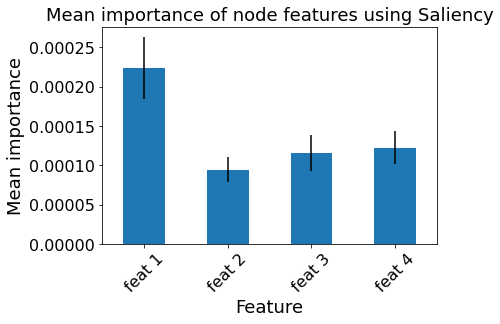

In [266]:
df = pd.DataFrame(data=mask.detach().numpy(), index=None, columns=['feat 1','feat 2','feat 3','feat 4'])
mymean = df.mean()
mysem = df.sem()

p = mymean.plot(legend=False,kind="bar",rot=45,fontsize=16,yerr=mysem);
p.set_title("Mean importance of node features using Saliency", fontsize=18);
p.set_xlabel("Feature", fontsize=18);
p.set_ylabel("Mean importance", fontsize=18);


# Get edge importances


In [267]:
def tmp(edge_weight):
    return model(G, G.ndata['h_n'].float(), edge_weight)

ig = IntegratedGradients(tmp)
# make sure that the internal batch size is the same as the number of nodes for node
# feature, or edges for edge feature
mask = ig.attribute(edge_weight, target=0,
internal_batch_size=G.num_edges(), n_steps=50)

In [268]:
npmsk = mask.detach().numpy()
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)

count =0
for u,v,d in nx_G.edges(data=True):
    d['weight'] = npmsk[count]
    count = count+1


In [269]:

widths = nx.get_edge_attributes(nx_G, 'weight')
nodelist = nx_G.nodes()

In [270]:
widths.values()
widths.update({n: 10000 *widths[n] for n in widths.keys()})

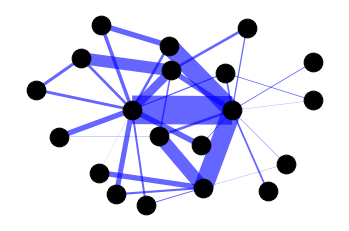

In [271]:


nx.draw_networkx_nodes(nx_G,pos,
                       nodelist=nodelist,
                       node_size=350,
                       node_color='black',
                       alpha=1)
nx.draw_networkx_edges(nx_G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='blue',
                       alpha=0.6)

plt.box(False)
plt.show()

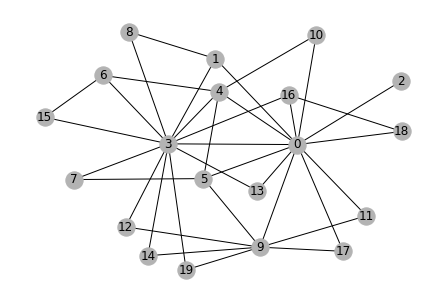

In [272]:
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Reproduce example with molecules (known ground truth)

In [286]:
dataset = dgl.data.TUDataset('Mutagenicity')

Extracting file to /root/.dgl/Mutagenicity


In [287]:
dataset

array([2])

In [308]:
num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=25, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [309]:
data = batch[0]
data

Graph(num_nodes=145, num_edges=294,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'edge_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [310]:
class GCN_edgefeats(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN_edgefeats, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.w = EdgeWeightNorm()
        self.out_act = nn.Sigmoid()
    def forward(self, g, in_feat,edge_weight):
        norm = self.w(g, edge_weight)
        h = self.conv1(g, in_feat,edge_weight=norm)
        h = F.relu(h)
        h = self.conv2(g, h,edge_weight=norm)
        g.ndata['h'] = h
        return self.out_act(dgl.mean_nodes(g, 'h'))

In [311]:
# Create the model with given dimensions
model = GCN_edgefeats(1, 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        edge_weight = (torch.ones(batched_graph.num_edges())).requires_grad_()
        pred = model(batched_graph, batched_graph.ndata['node_labels'].float(),edge_weight)
        loss = loss_func(pred.round(), labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


DGLError: ignored

In [301]:
pred.round().shape

torch.Size([5, 1])

In [303]:
labels.float()

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.]])